There are a number of different filters available. This notebook was to gain intuitive understanding on what the ouput of these filters are.


In [ ]:
# coming soon

In [1]:
###################################################################
# Built-in modules ################################################
###################################################################

import sys
import os
sys.path.append("../../")

import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob
from skimage.filters import laplace, median, meijering, sato, frangi, hessian, prewitt, sobel, scharr

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.NumbaPatchMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:

ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_005_EXP_003-PatchMatch-MacLean_well_known_filters"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()


['im2.png', 'im6.png', 'disp2.png', 'teddy_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\teddy_nonocc.png
['im2.png', 'im6.png', 'disp2.png', 'cones_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\cones_nonocc.png


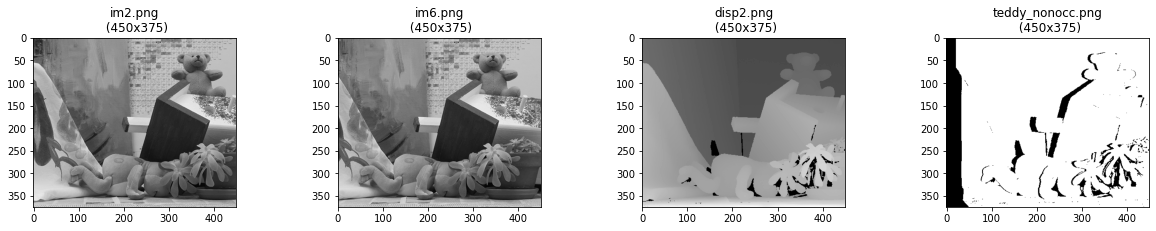

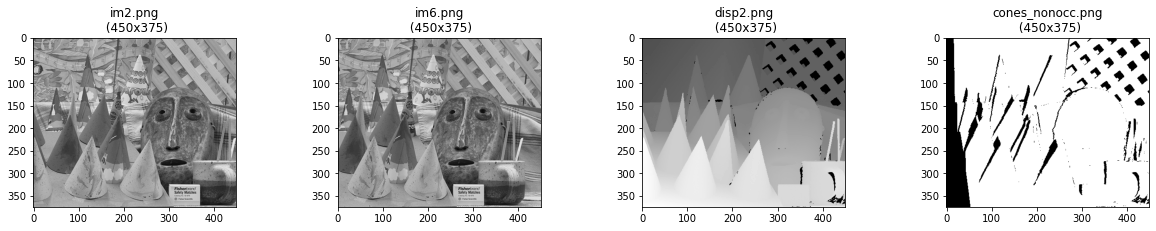

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

In [4]:
len(loaded_imgs_and_paths)

2

In [5]:
def identity(image, **kwargs):
    """Return the original image, ignoring any kwargs."""
    return image

### The effect of applying the named filters to images

<Figure size 432x288 with 0 Axes>

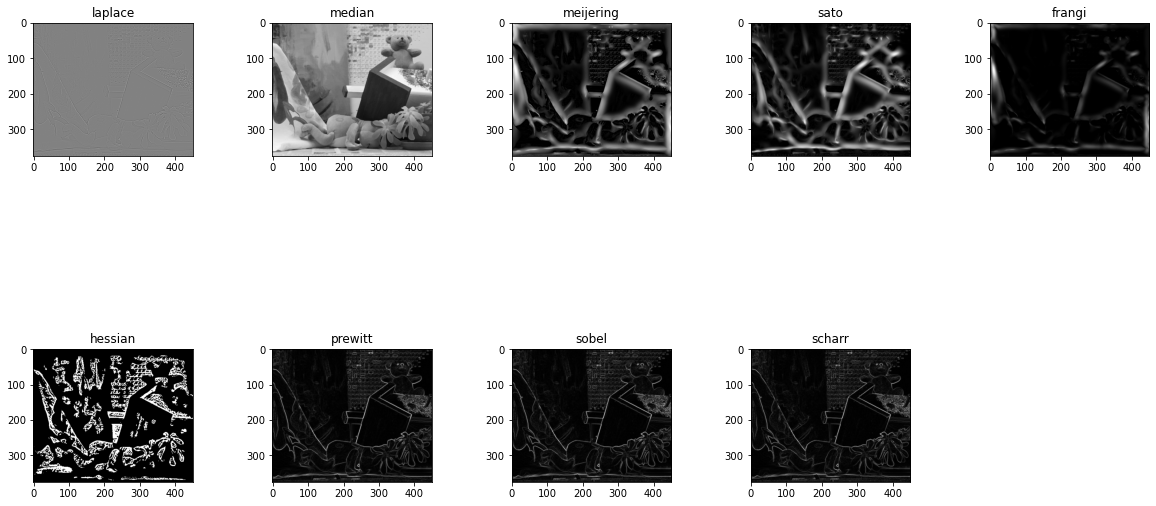

In [6]:
edge_filters = [hessian, prewitt, sobel, scharr]
ridge_detectors = [meijering, sato, frangi]
all_filters = [laplace, median, meijering, sato, frangi, hessian, prewitt, sobel, scharr]


fig = plt.figure()
plt.subplots(3,3, figsize=[20, 10])
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plot_counter = 1

image_to_be_used_for_demonstration = loaded_imgs_and_paths[0][0][0]


for i, filter in enumerate(all_filters):
    left = filter(image_to_be_used_for_demonstration)
    ax = plt.subplot(2,5, plot_counter)
    plot_counter+=1
    ax.set_title(filter.__name__)
    plt.imshow(left, cmap="gray")
    

Edge detection filters

In [7]:
###################################################################
# Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 60
GAP = -20
EGAP = -1


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

Directory '..\..\experiments\logs' already exists.

In [8]:
###################################################################
# Matching ####################################################
###################################################################

EXP_PARAMS["init_method"] = "maclean_et_al"



patches = [np.ones((1,1)), np.ones((3,3)), np.ones((5,5)), np.ones((7,7)),
           np.ones((3,1)), np.ones((1,3)), np.ones((5,1)), np.ones((1,5)), np.ones((7,1)), np.ones((1,7)),
           np.ones((5,3)), np.ones((3,5)), np.ones((7,3)), np.ones((3,7)),
           np.ones((7,5)), np.ones((5,7)),
           np.ones((9,3)), np.ones((11,3)),
           np.ones((13,3)), np.ones((15,3))
          ]


progress_bar = SimpleProgressBar.get_instance()

progress_counter = 1
steps_to_be_taken = len(SCENES)*len(all_filters)*len(patches)*3


SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)

saved_image_names = []
results = []

In [9]:
for match_value in (10,120, 10):
    EXP_PARAMS["match"] = MATCH = match_value
    matcher = m(MATCH, GAP, EGAP)
    matcher.configure_instance()

    for j, f in enumerate(all_filters):
        for p in patches:
            
            matcher.set_filter(p)

            for i, scene in enumerate(SCENES):

                EXP_PARAMS["scene"] = scene
                EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
                EXP_PARAMS["kernel_size"] = "{0}x{1}".format(p.shape[0], p.shape[1])

                EXP_PARAMS["preprocessing_method"] = f.__name__
                occ = loaded_imgs_and_paths[i][0][3]
                gt = loaded_imgs_and_paths[i][0][2]

                left = loaded_imgs_and_paths[i][0][0]
                right = loaded_imgs_and_paths[i][0][1]
                filtered_left = f(loaded_imgs_and_paths[i][0][0])
                filtered_right = f(loaded_imgs_and_paths[i][0][1])

                combined_left = (left+filtered_left).astype(np.float64)
                combined_right = (right+filtered_right).astype(np.float64)

                matcher.set_images(combined_left, combined_right)


                tic = time.time()

                x,raw_disp_map = matcher.test_pipeline()
                toc = time.time()

                EXP_PARAMS["runtime"] = toc-tic

                disp = raw_disp_map
                disp = 4*disp

                results.append(disp)
                temp_path = u.save_disparity(SAVE_PATH, disp)
                saved_image_names.append(os.path.split(temp_path)[-1])
                
                EXP_PARAMS["image_filename"] = temp_path

                EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

                EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
                BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

                csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

                EXP_PARAMS["are_occlusions_errors"]  = True
                EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
                BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

                csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

                progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
                progress_counter+=1

Experiment on patch sizes in progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00 % completed: 1080 / 1080 steps

In [10]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="mse", inplace=True) 
experiment_log.head(30)

,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
1680,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1229993.0,530.263330,8.330408,8848.384655,0.702908,0.552106,0.347333,0.143927,19.488245
240,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1229993.0,530.263330,8.330408,8848.384655,0.702908,0.552106,0.347333,0.143927,21.333209
1600,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1230679.0,531.383810,8.335054,8857.728321,0.703388,0.554944,0.353672,0.148743,19.241793
160,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1230679.0,531.383810,8.335054,8857.728321,0.703388,0.554944,0.353672,0.148743,22.276843
2000,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1242759.0,534.806801,8.416868,8886.211735,0.707797,0.559028,0.354932,0.147463,21.248132
560,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1242759.0,534.806801,8.416868,8886.211735,0.707797,0.559028,0.354932,0.147463,19.671276
640,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1244147.0,535.395703,8.426269,8891.102912,0.708082,0.559339,0.355060,0.147822,20.944172
2080,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1244147.0,535.395703,8.426269,8891.102912,0.708082,0.559339,0.355060,0.147822,34.962364
480,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1241665.0,535.497890,8.409459,8891.951361,0.707967,0.559014,0.354525,0.147077,21.564355
1920,ALG_005_EXP_003-PatchMatch-MacLean_well_known_...,10,-20,-1,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,teddy,..\..\experiments\disparities\ALG_005_EXP_003-...,450x375,...,False,1241665.0,535.497890,8.409459,8891.951361,0.707967,0.559014,0.354525,0.147077,19.826599


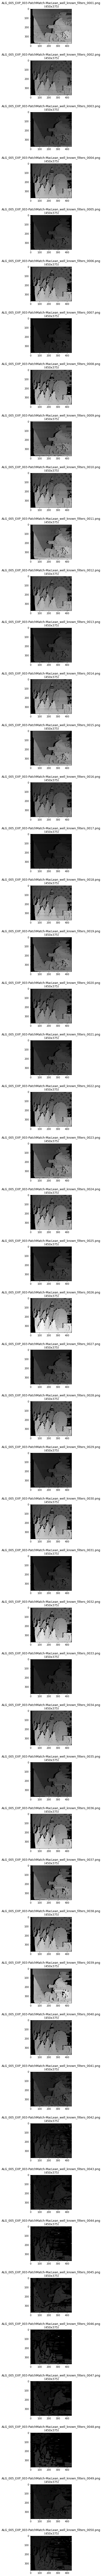

In [11]:
plu.plot_images(results[0:50], saved_image_names[0:50], ncols= 1)

In [12]:
edge_filters = [hessian, prewitt, sobel, scharr]
ridge_detectors = [meijering, sato, frangi]
additional_filters = [laplace, median]

edge_enhanced = []
ridge_enhanced = []
all_enhanced = []


for i, scene in enumerate(SCENES):
    left = loaded_imgs_and_paths[i][0][0]
    right = loaded_imgs_and_paths[i][0][1]
    
    edge_enhanced_temp = [np.zeros(loaded_imgs_and_paths[i][0][0].shape), np.zeros(loaded_imgs_and_paths[i][0][0].shape)]
    ridge_enhanced_temp = [np.zeros(loaded_imgs_and_paths[i][0][0].shape), np.zeros(loaded_imgs_and_paths[i][0][0].shape)]
    all_enhanced_temp = [np.zeros(loaded_imgs_and_paths[i][0][0].shape), np.zeros(loaded_imgs_and_paths[i][0][0].shape)]

    for edger in edge_filters:
        edge_enhanced_temp[0]+=edger(left)
        edge_enhanced_temp[1]+=edger(right)

    for ridger in ridge_detectors:
        ridge_enhanced_temp[0]+=ridger(left)
        ridge_enhanced_temp[1]+=ridger(right)
        
    for each in additional_filters:
        all_enhanced_temp[0]+=each(left)
        all_enhanced_temp[1]+=each(right)
        
    all_enhanced_temp[0]+=edge_enhanced_temp[0]
    all_enhanced_temp[1]+=edge_enhanced_temp[1]
    all_enhanced_temp[0]+=ridge_enhanced_temp[0]
    all_enhanced_temp[1]+=ridge_enhanced_temp[1]
    all_enhanced_temp[0]+=left
    all_enhanced_temp[1]+=right
    
    edge_enhanced_temp[0]+=left
    edge_enhanced_temp[1]+=right
    
    ridge_enhanced_temp[0]+=left
    ridge_enhanced_temp[1]+=right
    
    edge_enhanced.append(edge_enhanced_temp)
    ridge_enhanced.append(ridge_enhanced_temp)
    all_enhanced.append(all_enhanced_temp)


In [19]:
enhanced_versions = dict(edge=edge_enhanced, ridge=ridge_enhanced, all=all_enhanced)
progress_counter = 1
steps_to_be_taken = len(SCENES)*len(patches)*3*12

In [ ]:
for match_value in (10,120, 10):
    EXP_PARAMS["match"] = MATCH = match_value
    matcher = m(MATCH, GAP, EGAP)
    matcher.configure_instance()
    for p in patches:

        matcher.set_filter(p)

        for i, scene in enumerate(SCENES):
            for k,v in enhanced_versions.items():
                EXP_PARAMS["scene"] = scene
                EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
                EXP_PARAMS["kernel_size"] = "{0}x{1}".format(p.shape[0], p.shape[1])

                EXP_PARAMS["preprocessing_method"] = k
                occ = loaded_imgs_and_paths[i][0][3]
                gt = loaded_imgs_and_paths[i][0][2]

                left = v[i][0]
                right =v[i][1]

                matcher.set_images(left, right)


                tic = time.time()

                x,raw_disp_map = matcher.test_pipeline()
                toc = time.time()

                EXP_PARAMS["runtime"] = toc-tic

                disp = raw_disp_map
                disp = 4*disp

                results.append(disp)
                temp_path = u.save_disparity(SAVE_PATH, disp)
                saved_image_names.append(os.path.split(temp_path)[-1])

                EXP_PARAMS["image_filename"] = temp_path

                EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

                EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
                BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

                csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

                EXP_PARAMS["are_occlusions_errors"]  = True
                EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
                BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

                csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

                progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
                progress_counter+=1

In [ ]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="mse", inplace=True) 
experiment_log.head(30)